<a href="https://colab.research.google.com/github/theodoriss/Effective-LSTM-for_target-dependent-sentiment-classification/blob/master/TD_TC_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks for Data Science Applications (2019/2020)

Final exam (template)

Students: Theodoros Sofianos (1867968); 
Alessandra Griesi (1578970)

Reference paper / topic: Effective LSTMs for Target-Dependent Sentiment Classification Duyu Tang, Bing Qin, Xiaocheng Feng, Ting Liu

https://www.aclweb.org/anthology/C16-1311.pdf

### Report

The goal of this work is to find the model that mostly can classify correctly  tweets. Tweets are sentences, indeed. 
And the texts can be classified regarding the feeling of a message (positive, negative, neutral).
It's been considered the LSTM model, that is a type of Recurrent Neural Network used for text.

                                                           LSTM Model 

<body>
    <img src="https://drive.google.com/uc?export=view&id=1-MymVt0RL9EYsEcjiouxbY4eKWyueQwA">
</body>

LSTM Layer 

\begin{equation} it = σ(Wi · [ht−1; wt] + bi) \end{equation}
\begin{equation} ft = σ(Wf · [ht−1; wt] + bf ) \end{equation}
\begin{equation} ot = σ(Wo · [ht−1; wt] + bo) \end{equation}
\begin{equation}gt = tanh(Wr · [ht−1; wt] + br) \end{equation}
\begin{equation}ct = it \odot gt + ft \odot ct−1 \end{equation}
\begin{equation} ht = ot \odot tanh(ct) \end{equation}

made actually by four interacting layers.


More in particular, we compared different ways of using the LSTM. 
The simple use of LSTM is not performant as a more complex way to give data to the LSTM.

Thus, we implemented the two models focusing on how the target could help for predicting the dominant sentiment for each tweet.

                                                     New implementation of the model 

<body>
    <img src="https://drive.google.com/uc?export=view&id=1Imn48rCSppPpEyc5uwgvpcQjFMvFR7YT">
</body>



Basically these two models are made of two models (still LSTM-based) that take care of one portion of the tweet: one the left one, and the other the right one.   What differs is how the target word(/s) is(/are) given to the model.

The first one, called Target Dependent LSTM has the target word considered in the last step of the LSTM:
it means that when the LSTM works over a sentence, the information regarding the target is considered as last.

In the second implementation, each word in the sentence is concatenated to the target vector.


# Install  Dependencies


In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from nltk.stem import PorterStemmer
import string
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Embedding,LSTM,Concatenate,concatenate,Dropout,Input,RepeatVector,Masking,BatchNormalization
from tensorflow.keras.initializers import Constant # the word embedding matrix is pre-trained,thus constant
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
import gensim.downloader as api
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data


In [ ]:
def create_dataframe(file_path):
    sentences=[] # list of lists, where every sentence is a list of the words that form it. will be used for splitting right and left of target
    #sentences_text=[]  # list of strings-sentences. replace target symbol with target, to be used in tokenization
    target=[]
    label=[]
    with open(file_path,encoding='utf-8') as file:
        for line in file:
            sentences.append(line.strip('\n').lower().split()) 
            #sentences_text.append(line.strip('\n').lower())
            target.append(next(file).strip('\n'))
            label.append(int(next(file).strip('\n')))
    #for i in range(len(sentences_text)):
        #sentences_text[i]=sentences_text[i].replace('$t$',str(target[i])) # replace symbol with target

    words_left=[]# list of lists
    words_right=[]# list of lists
    for target_number,sentence in enumerate(sentences):
        for position,word in enumerate(sentence):
            if word=='$t$':
                words_left.append(sentence[:position]+[target[target_number]])
                #wr=[target[target_number]]+sentence[position+1:]
                #wr.reverse()
                words_right.append([target[target_number]]+sentence[position+1:])
                break

    data=pd.DataFrame(columns=['sentence','words_left','words_right','target','label'])
    data['sentence']=sentences
    data['words_left']=words_left
    data['words_right']=words_right
    data['target']=target
    data['label']=label

    data['sentence']= data.apply(lambda x: ' '.join(x['sentence']).replace('$t$',x['target']).split(),axis=1) # replace $t$ symbol with its target value

    return data

In [ ]:
train_data=create_dataframe('train1.raw')
test_data=create_dataframe('test.raw')
train_data.head()

,sentence,words_left,words_right,target,label
0,"[hi, my, name, is, harry, and, i, hate, britne...","[hi, my, name, is, harry, and, i, hate, britne...",[britney spears],britney spears,-1
1,"[yes, i, am, especially, when, i, sing, britne...","[yes, i, am, especially, when, i, sing, britne...",[britney spears],britney spears,1
2,"[lol, well, the, main, reason, was, i, hardly,...","[lol, well, the, main, reason, was, i, hardly,...","[xbox, games, ., that, plus, netflix, lol]",xbox,0
3,"[barack, obama, used, the, internet, to, his, ...",[barack obama],"[barack obama, used, the, internet, to, his, a...",barack obama,0
4,"[google, translate, sucks, !]",[google],"[google, translate, sucks, !]",google,-1


# Preprocess of data and transormation of sentences into numeric sequences

In [ ]:
def preprocessing(list_of_sentences,dataframe):
    processed_sentences=[]
    stops = set(stopwords.words("english"))
    ps = PorterStemmer()
    for s in list_of_sentences:
       # print(str(s).translate(str.maketrans('', '', string.punctuation)))
        text = [w for w in s if not w in stops and len(w)>2]
       # print(' '.join(text))
        temp=[]
        for w in text:
            if w not in ' '.join(list(dataframe['target'])):
                rootword=ps.stem(w)
                temp.append(rootword)
            else:
                temp.append(w)
        processed_sentences.append(str(temp).translate(str.maketrans('', '', string.punctuation)))
    return processed_sentences

In [ ]:
train_processed = train_data.apply(lambda x: preprocessing(x,train_data) if x.name in ['sentence', 'words_left','words_right'] else x)
test_processed = test_data.apply(lambda x: preprocessing(x,test_data) if x.name in ['sentence', 'words_left','words_right'] else x)



In [ ]:
def create_sequences(tokenizer,dataframe):
    MAX_SEQUENCE_LENGTH = 14 # largest sequence length for left,right words from both train and test sets
    MAX_SEQUENCE_LENGTH_sentences = 17 # largest sequence for the whole sentence


    tokens_left = tokenizer.texts_to_sequences(dataframe['words_left'])
    tokens_right = tokenizer.texts_to_sequences(dataframe['words_right'])
    tokens_all = tokenizer.texts_to_sequences(dataframe['sentence'])
    tokens_left= sequence.pad_sequences(tokens_left, padding='pre',maxlen=MAX_SEQUENCE_LENGTH)
    tokens_right= sequence.pad_sequences(tokens_right, padding='post',maxlen=MAX_SEQUENCE_LENGTH)
    tokens_all= sequence.pad_sequences(tokens_all, padding='pre',maxlen=MAX_SEQUENCE_LENGTH_sentences)

    return tokens_left,tokens_right,tokens_all
    

In [ ]:
def create__inputs_outputs(train_dataframe,test_dataframe):
    number_of_words=250
    tokenizer = text.Tokenizer(num_words=number_of_words)
    tokenizer.fit_on_texts(train_dataframe['sentence'])
    
    train_tokens_left,train_tokens_right,train_tokens_all=create_sequences(tokenizer,train_dataframe)
    test_tokens_left,test_tokens_right,test_tokens_all=create_sequences(tokenizer,test_dataframe)

    
    labels_train= np.asanyarray(pd.get_dummies(train_dataframe['label'],prefix=['label']))
    labels_test= np.asanyarray(pd.get_dummies(test_dataframe['label'],prefix=['label']))

    
    return tokenizer,train_tokens_left,train_tokens_right,train_tokens_all,test_tokens_left,test_tokens_right,test_tokens_all,labels_train,labels_test

    

In [ ]:
tokenizer,X_train_left,X_train_right,X_train,X_test_left,X_test_right,X_test,Y_train,Y_test=create__inputs_outputs(train_processed,test_processed)

In [ ]:
word2vec = api.load("glove-twitter-100")


[=================================================-] 98.9% 382.8/387.1MB downloaded

In [ ]:
def create_matrix_L(tokenizer,word2vec):
    df=np.zeros((len(tokenizer.index_word),word2vec.vector_size),dtype='float')
    for number,word in enumerate(tokenizer.index_word.values()):
        if word in word2vec.wv.vocab:
            df[number]=word2vec[word]
    return df

In [ ]:
L=create_matrix_L(tokenizer,word2vec)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [ ]:
stopping = EarlyStopping(monitor='val_loss', patience=4,restore_best_weights=False,verbose=1)


# Normal LSTM model

In [ ]:
def LSTM_model(L,train_tokens,num_classes=3):
    model = Sequential()
    model.add(Masking(mask_value=0))
    model.add(Embedding(L.shape[0],L.shape[1], input_length=train_tokens.shape[1],embeddings_initializer=Constant(L),trainable=False))
    #model.add(BatchNormalization())
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.1,recurrent_activation='sigmoid',recurrent_regularizer='l2'))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
model_LSTM=LSTM_model(L,X_train)

In [ ]:
model_LSTM.fit(X_train,Y_train,batch_size=64,epochs=30,verbose=False,validation_split=0.2,use_multiprocessing=True,workers=0,callbacks=[stopping])

Epoch 00016: early stopping


The returned "history" object holds a record of the loss values and metric values during training

In [ ]:
hist_lstm=model_LSTM.history.history

In [ ]:
model_LSTM.evaluate(X_test,Y_test,batch_size=64,verbose=0,workers=0,use_multiprocessing=True)

[0.879388153553009, 0.6257225275039673]

In [ ]:
preds = model_LSTM.predict(X_test,verbose=0)

Ypred = np.argmax(preds, axis=1)
#Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(np.argmax(Y_test,axis=1), Ypred, labels=None,target_names=['-1','0','1'], digits=3))

              precision    recall  f1-score   support

          -1      0.589     0.497     0.539       173
           0      0.652     0.751     0.698       346
           1      0.592     0.503     0.544       173

    accuracy                          0.626       692
   macro avg      0.611     0.584     0.594       692
weighted avg      0.621     0.626     0.620       692



In [ ]:
print(confusion_matrix(np.argmax(Y_test,axis=1),Ypred))

[[ 86  73  14]
 [ 40 260  46]
 [ 20  66  87]]


# TD-LSTM-evaluate

### LSTM-left


In [ ]:
def LSTM_model_left(L,train_tokens,num_classes=3,MAX_SEQUENCE_LENGTH=14):
    model = Sequential()
    #model.add(Masking(mask_value=0))
    model.add(Embedding(L.shape[0],L.shape[1], input_length=train_tokens.shape[1],embeddings_initializer=Constant(L),trainable=False))
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.1,recurrent_activation='sigmoid',recurrent_regularizer='l2'))
    model.add(Dropout(0.3))


    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model_LSTM_left=LSTM_model_left(L,X_train_left)

In [ ]:
model_LSTM_left.fit(X_train_left,Y_train,batch_size=64,epochs=30,verbose=1,validation_split=0.2,use_multiprocessing=True,workers=0,callbacks=[stopping])

Epoch 1/30
71/71 [==============================] - 3s 40ms/step - loss: 1.4833 - accuracy: 0.5033 - val_loss: 1.1168 - val_accuracy: 0.5381
Epoch 2/30
71/71 [==============================] - 3s 36ms/step - loss: 1.0460 - accuracy: 0.5485 - val_loss: 0.9734 - val_accuracy: 0.5646
Epoch 3/30
71/71 [==============================] - 3s 36ms/step - loss: 0.9680 - accuracy: 0.5578 - val_loss: 0.9288 - val_accuracy: 0.5779
Epoch 4/30
71/71 [==============================] - 3s 36ms/step - loss: 0.9358 - accuracy: 0.5717 - val_loss: 0.9177 - val_accuracy: 0.5912
Epoch 5/30
71/71 [==============================] - 3s 35ms/step - loss: 0.9261 - accuracy: 0.5803 - val_loss: 0.9160 - val_accuracy: 0.5858
Epoch 6/30
71/71 [==============================] - 3s 36ms/step - loss: 0.9200 - accuracy: 0.5795 - val_loss: 0.9040 - val_accuracy: 0.6000
Epoch 7/30
71/71 [==============================] - 3s 35ms/step - loss: 0.9073 - accuracy: 0.5905 - val_loss: 0.9022 - val_accuracy: 0.5982
Epoch 8/30
71

### LSTM-right


In [ ]:
def LSTM_model_right(L,train_tokens,num_classes=3,MAX_SEQUENCE_LENGTH=14):
    model = Sequential()
    #model.add(Masking(mask_value=0))
    model.add(Embedding(L.shape[0],L.shape[1], input_length=train_tokens.shape[1],embeddings_initializer=Constant(L),trainable=False))
    model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.1,recurrent_activation='sigmoid',recurrent_regularizer='l2',go_backwards=True))
    model.add(Dropout(0.3))


    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model_LSTM_right=LSTM_model_right(L,X_train_right)

In [ ]:
model_LSTM_right.fit(X_train_right,Y_train,batch_size=64,epochs=30,verbose=1,validation_split=0.2,use_multiprocessing=True,workers=0,callbacks=[stopping])

Epoch 1/30
71/71 [==============================] - 3s 39ms/step - loss: 1.5084 - accuracy: 0.4947 - val_loss: 1.1530 - val_accuracy: 0.5274
Epoch 2/30
71/71 [==============================] - 3s 36ms/step - loss: 1.0631 - accuracy: 0.5394 - val_loss: 0.9920 - val_accuracy: 0.5531
Epoch 3/30
71/71 [==============================] - 3s 36ms/step - loss: 0.9796 - accuracy: 0.5587 - val_loss: 0.9662 - val_accuracy: 0.5637
Epoch 4/30
71/71 [==============================] - 3s 36ms/step - loss: 0.9479 - accuracy: 0.5606 - val_loss: 0.9467 - val_accuracy: 0.5584
Epoch 5/30
71/71 [==============================] - 3s 42ms/step - loss: 0.9254 - accuracy: 0.5861 - val_loss: 0.9352 - val_accuracy: 0.5726
Epoch 6/30
71/71 [==============================] - 5s 67ms/step - loss: 0.9263 - accuracy: 0.5748 - val_loss: 0.9267 - val_accuracy: 0.5858
Epoch 7/30
71/71 [==============================] - 3s 46ms/step - loss: 0.9092 - accuracy: 0.5854 - val_loss: 0.9281 - val_accuracy: 0.5805
Epoch 8/30
71

### Merge the 2 LSTM layers and feed them to another network

In [ ]:
def concatenate_networks(model_left,model_right,num_classes=3):
    left_vector=model_left.layers[-3].output
    right_vector=model_right.layers[-3].output # concatenate the 2nd to last layers
    
    merged=Concatenate()([left_vector,right_vector])
    output=Dropout(0.1)(merged)
    
    output= Dense(num_classes, activation='softmax')(output)

    
    merged_model=Model([model_left.input,model_right.input],output)


    #model= Dense(num_classes, activation='softmax')(merged)
    for idx,layer in enumerate(merged_model.layers):
        if idx+1<len(merged_model.layers): # train only the last layer,activated by softmax
            layer.trainable = False
        #print(idx+1,len(merged_model.layers))
    merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    return merged_model

In [ ]:
model_TD=concatenate_networks(model_LSTM_left,model_LSTM_right)

In [ ]:
model_TD.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_6_input (InputLayer)  [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding_7_input (InputLayer)  [(None, 14)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 14, 100)      978000      embedding_6_input[0][0]          
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 14, 100)      978000      embedding_7_input[0][0]          
____________________________________________________________________________________________

In [ ]:
history2.fit([X_train_left,X_train_right],Y_train,batch_size=128,epochs=30,verbose=False,validation_split=0.2,workers=0,use_multiprocessing=True,callbacks=[stopping])

Epoch 00016: early stopping


In [ ]:
hist_td_lstm=history2.history.history

In [ ]:
preds = history2.predict([X_test_left,X_test_right],verbose=0)

Ypred = np.argmax(preds, axis=1)
#Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(np.argmax(Y_test,axis=1), Ypred, labels=None,target_names=['-1','0','1'], digits=3))

              precision    recall  f1-score   support

          -1      0.623     0.497     0.553       173
           0      0.652     0.786     0.713       346
           1      0.613     0.486     0.542       173

    accuracy                          0.639       692
   macro avg      0.630     0.590     0.603       692
weighted avg      0.635     0.639     0.630       692



In [ ]:
print(confusion_matrix(np.argmax(Y_test,axis=1),Ypred))

[[ 86  73  14]
 [ 35 272  39]
 [ 17  72  84]]


####TC-LSTM

In [ ]:
def create_target_vector_array(dataframe,word2vec):
    target_vector=np.empty([len(dataframe),word2vec.vector_size])
    for number,target in enumerate(dataframe.target):
        y=np.zeros(word2vec.vector_size) 
        for t in target.split():
            if t in word2vec.wv.vocab.keys():
                y+= word2vec.wv[t]
        target_vector[number]= y/len(target.split())
    return target_vector

In [ ]:
target_vector_array_train=create_target_vector_array(train_processed,word2vec)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [ ]:
def LSTM_TC_model_left(L,train_tokens,target_vector_array,num_classes=3):
    MAX_SEQUENCE_LENGTH = len(max(train_tokens,key=len))
    input_tokens=Input(shape=MAX_SEQUENCE_LENGTH,dtype='int32')
    input_target_vector=Input(shape=target_vector_array.shape[1],dtype='float32')
    
    embb= Embedding(L.shape[0],L.shape[1], input_length=train_tokens.shape[1],embeddings_initializer=Constant(L),trainable=False)(input_tokens)
    repeat_target= RepeatVector(MAX_SEQUENCE_LENGTH)(input_target_vector) #plut the word vector to each input of the LSTM
    conc=Concatenate(axis=-1)([embb,repeat_target])
    lstm= LSTM(100, dropout=0.3, recurrent_dropout=0.1,recurrent_regularizer='l2')(conc)
    #lstm=Dropout(0.3)(lstm)
    
    
    #dense=Dense(64)(lstm)
    #dense=BatchNormalization()(dense)

    #dense=Dropout(0.3)(dense)


    output = Dense(num_classes, activation='softmax')(lstm)
    model=Model([input_tokens,input_target_vector],outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



In [ ]:
def LSTM_TC_model_right(L,train_tokens,target_vector_array,num_classes=3):
    MAX_SEQUENCE_LENGTH = len(max(train_tokens,key=len))

    input_tokens=Input(shape=MAX_SEQUENCE_LENGTH,dtype='int32')
    input_target_vector=Input(shape=target_vector_array.shape[1],dtype='float32')
    
    embb= Embedding(L.shape[0],L.shape[1], input_length=train_tokens.shape[1],embeddings_initializer=Constant(L),trainable=False)(input_tokens)
    repeat_target= RepeatVector(MAX_SEQUENCE_LENGTH)(input_target_vector)
    conc=Concatenate(axis=-1)([embb,repeat_target])
    lstm= LSTM(100, dropout=0.3, recurrent_dropout=0.1,go_backwards=True)(conc)
    #lstm=Dropout(0.3)(lstm)
    
    
    #dense=Dense(64)(lstm)
    #dense=BatchNormalization()(dense)

    #dense=Dropout(0.3)(dense)


    output = Dense(num_classes, activation='softmax')(lstm)
    model=Model([input_tokens,input_target_vector],outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model




In [ ]:
model_LSTM_left=LSTM_TC_model_left(L,X_train_left,target_vector_array_train)


In [ ]:
model_LSTM_left.fit([X_train_left,target_vector_array_train],Y_train,batch_size=128,epochs=30,verbose=0,validation_split=0.2,use_multiprocessing=True,workers=0,callbacks=[stopping])



Epoch 00026: early stopping


In [ ]:
model_LSTM_right=LSTM_TC_model_right(L,X_train_right,target_vector_array_train)

In [ ]:
model_LSTM_right.fit([X_train_right,target_vector_array_train],Y_train,batch_size=128,epochs=30,verbose=0,validation_split=0.2,use_multiprocessing=True,workers=0,callbacks=[stopping])

Epoch 00020: early stopping


In [ ]:
def TC_LSTM(model_left,model_right,num_classes=3):
    left_vector=model_left.layers[-2].output
    right_vector=model_right.layers[-2].output 
    
    merged=Concatenate()([left_vector,right_vector]) # concatenate the two LSTM layers of the previous models
    output=Dropout(0.3)(merged)
    
    output= Dense(num_classes, activation='softmax')(output)

    
    merged_model=Model([model_left.input,model_right.input],output)


    #model= Dense(num_classes, activation='softmax')(merged)
    for idx,layer in enumerate(merged_model.layers):
        if idx+1<len(merged_model.layers): # train only the last layer,activated with softmax
            layer.trainable = False
        #print(idx+1,len(merged_model.layers))
    merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


    return merged_model



In [ ]:
history3=TC_LSTM(model_LSTM_left,model_LSTM_right)


In [ ]:
history3.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 100)]        0                                            
____________________________________________________________________________________________

In [ ]:
history3.fit([X_train_left,target_vector_array_train,X_train_right,target_vector_array_train],Y_train,batch_size=128,epochs=30,verbose=False,validation_split=0.2,workers=0,use_multiprocessing=True,callbacks=[stopping])

Epoch 00016: early stopping


In [ ]:
hist_tc_lstm=history3.history.history

In [ ]:
target_vector_array_test=create_target_vector_array(test_processed,word2vec)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys


In [ ]:
history3.evaluate([X_test_left,target_vector_array_test,X_test_right,target_vector_array_test],Y_test,batch_size=128,verbose=0,workers=0,use_multiprocessing=True)

[0.8478884100914001, 0.6517341136932373]

In [ ]:
preds = history3.predict([X_test_left,target_vector_array_test,X_test_right,target_vector_array_test],verbose=0)

Ypred = np.argmax(preds, axis=1)

print(classification_report(np.argmax(Y_test,axis=1), Ypred, labels=None,target_names=['negative','neutral','positive'], digits=3))



              precision    recall  f1-score   support

    negative      0.617     0.503     0.554       173
     neutral      0.660     0.798     0.723       346
    positive      0.662     0.509     0.575       173

    accuracy                          0.652       692
   macro avg      0.646     0.603     0.617       692
weighted avg      0.650     0.652     0.644       692



In [ ]:
print(confusion_matrix(np.argmax(Y_test,axis=1),Ypred))


[[ 87  76  10]
 [ 35 276  35]
 [ 19  66  88]]


# Model Comparison

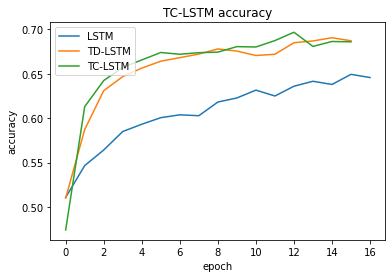

In [ ]:
def plot_history(models_list,names_list,metric):
    for n, model in enumerate (models_list):
    # summarize history for accuracy
       # plt.plot(model.history.history['accuracy'])
        plt.plot(model[metric])
        plt.title( names_list[n]+' '+ metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
    plt.legend([names_list[n-2],names_list[n-1],names_list[n]], loc='upper left')
    plt.show()


plot_history([hist_lstm,hist_td_lstm,hist_tc_lstm], ['LSTM','TD-LSTM','TC-LSTM'],'accuracy')


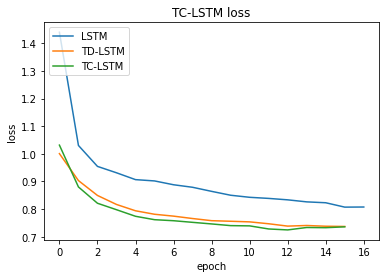

In [ ]:
plot_history([hist_lstm,hist_td_lstm,hist_tc_lstm], ['LSTM','TD-LSTM','TC-LSTM'],'loss')


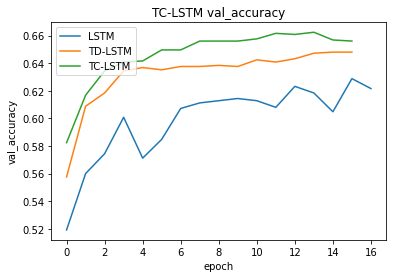

In [ ]:
plot_history([hist_lstm,hist_td_lstm,hist_tc_lstm], ['LSTM','TD-LSTM','TC-LSTM'],'val_accuracy')


In [ ]:
plot_history([hist_lstm,hist_td_lstm,hist_tc_lstm], ['LSTM','TD-LSTM','TC-LSTM'],'val_loss')

Comparing with our paper

<body>
<src = >
</body>

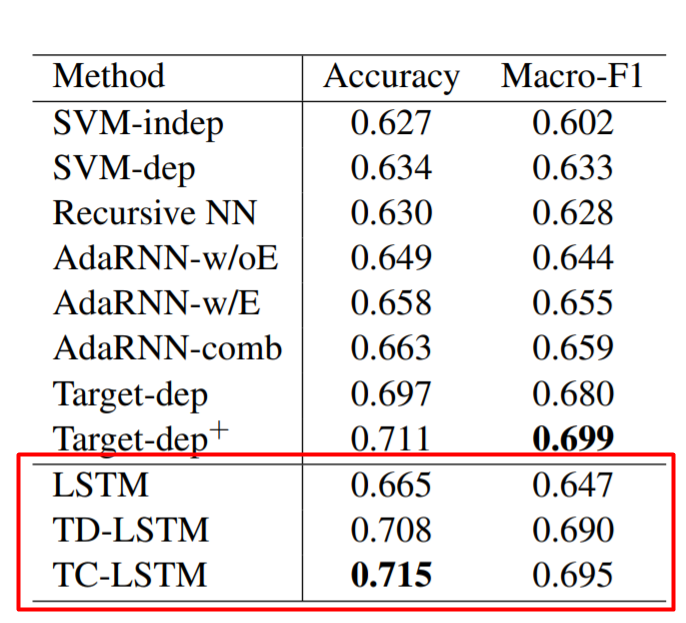

Checking with the Accuracies and the Macro-F1 we obtained :

<div align = 'center'>
$
\begin{array}{c c} 
{\huge Accuracy} & {\huge Macro-F1}\\
\\
{\huge 0.621} & {\huge 0.586} \\
{\huge 0.639} & {\huge 0.603} \\
{\huge 0.652} & {\huge 0.617} \\
\end{array}$
</div>

The accuracies are slightly lower than the paper's ones.








And from the bar graph:

<body>
<img src ="https://drive.google.com/uc?export=view&id=178z3EeBS_Eu_zPHUGQ02626Q0K2Rsruk">
</body>